In [1]:
from Bio import Phylo
import numpy as np
import matplotlib.pyplot as plt


def all_sublineage_ratios_array(newick_file):
    """
    Compute sublineage weight ratios for all internal nodes of a tree.
    
    Parameters
    ----------
    newick_file : str
        Path to the Newick tree file.
    
    Returns
    -------
    np.ndarray
        Flat array of sublineage weight ratios (child / parent) for all internal nodes.
    """
    tree = Phylo.read(newick_file, "newick")
    
    # Recursive function to count tips
    def count_tips(clade):
        if clade.is_terminal():
            return 1
        return sum(count_tips(child) for child in clade.clades)
    
    # Recursive function to compute ratios
    def compute_ratios(clade):
        ratios_list = []
        if not clade.is_terminal():
            parent_weight = count_tips(clade)
            for child in clade.clades:
                ratios_list.append(count_tips(child) / parent_weight)
            for child in clade.clades:
                ratios_list.extend(compute_ratios(child))
        return ratios_list
    
    all_ratios = compute_ratios(tree.root)
    return np.array(all_ratios)


def leaf_terminal_branch_ratio_all_branches(newick_file):
    """
    For each internal node, compute the ratio of the mean branch length of its 
    descendant leaves (terminal branches) to the mean branch length of all branches
    in the tree (internal + terminal).
    
    Parameters
    ----------
    newick_file : str
        Path to the Newick tree file.
    
    Returns
    -------
    np.ndarray
        Flat array of ratios (mean leaf branch length / mean branch length of all branches)
        for all internal nodes.
    """
    tree = Phylo.read(newick_file, "newick")
    
    # --- Compute mean branch length of all branches in the tree ---
    all_branch_lengths = [clade.branch_length for clade in tree.find_clades() 
                          if clade.branch_length is not None]
    mean_all_branches = np.mean(all_branch_lengths)
    
    # --- Recursive function to get terminal branch lengths under a clade ---
    def terminal_branch_lengths(clade):
        if clade.is_terminal():
            return [clade.branch_length if clade.branch_length is not None else 0.0]
        lengths = []
        for child in clade.clades:
            lengths.extend(terminal_branch_lengths(child))
        return lengths
    
    # --- Compute ratios for all internal nodes ---
    def compute_ratios(clade):
        ratios_list = []
        if not clade.is_terminal():
            term_lengths = terminal_branch_lengths(clade)
            mean_term = np.mean(term_lengths) if term_lengths else 0.0
            ratios_list.append(mean_term / mean_all_branches)
            for child in clade.clades:
                ratios_list.extend(compute_ratios(child))
        return ratios_list
    
    all_ratios = compute_ratios(tree.root)
    return np.array(all_ratios)





def leaf_terminal_branch_ratio_parents_of_leaves(newick_file):
    """
    For each internal node that is the parent of at least one leaf, 
    compute the ratio of the mean branch length of its descendant leaves 
    (terminal branches) to the mean branch length of all branches 
    (internal + terminal) in the tree.
    
    Parameters
    ----------
    newick_file : str
        Path to the Newick tree file.
    
    Returns
    -------
    np.ndarray
        Array of ratios (mean leaf branch length / mean branch length of all branches)
        for all internal nodes that have at least one leaf child.
    """
    tree = Phylo.read(newick_file, "newick")
    
    # --- Compute mean branch length of all branches in the tree ---
    all_branch_lengths = [clade.branch_length for clade in tree.find_clades() 
                          if clade.branch_length is not None]
    mean_all_branches = np.mean(all_branch_lengths)
    
    # --- Recursive function to get terminal branch lengths under a clade ---
    def terminal_branch_lengths(clade):
        if clade.is_terminal():
            return [clade.branch_length if clade.branch_length is not None else 0.0]
        lengths = []
        for child in clade.clades:
            lengths.extend(terminal_branch_lengths(child))
        return lengths
    
    # --- Collect ratios only for nodes that have at least one leaf child ---
    ratios_list = []
    for clade in tree.find_clades():
        if not clade.is_terminal():
            # Check if it has at least one leaf child
            leaf_children = [child for child in clade.clades if child.is_terminal()]
            if leaf_children:
                term_lengths = terminal_branch_lengths(clade)
                mean_term = np.mean(term_lengths) if term_lengths else 0.0
                ratios_list.append(mean_term / mean_all_branches)
    
    return np.array(ratios_list)







In [2]:
from Bio import Phylo
import numpy as np

def leaf_terminal_branch_ratio_parents_of_leaves2(newick_file):
    """
    For each internal node that is the parent of at least one leaf,
    compute the ratio:
        mean branch length of descendant leaves (terminal branches)
        /
        mean branch length of the lineage leading to that node
        (all branches along root → node path).
    
    Parameters
    ----------
    newick_file : str
        Path to the Newick tree file.
    
    Returns
    -------
    list of (clade, ratio)
        List of tuples with the clade and its ratio.
    """
    tree = Phylo.read(newick_file, "newick")
    
    # --- helper: get terminal branch lengths under a clade ---
    def terminal_branch_lengths(clade):
        if clade.is_terminal():
            return [clade.branch_length if clade.branch_length is not None else 0.0]
        lengths = []
        for child in clade.clades:
            lengths.extend(terminal_branch_lengths(child))
        return lengths
    
    # --- helper: get branch lengths along lineage root -> clade ---
    def lineage_branch_lengths(clade, tree):
        path = tree.get_path(clade)
        lengths = [c.branch_length for c in path if c.branch_length is not None]
        return lengths
    
    ratios_list = []
    for clade in tree.find_clades():
        if not clade.is_terminal():
            # node must have at least one leaf child
            leaf_children = [child for child in clade.clades if child.is_terminal()]
            if leaf_children:
                term_lengths = terminal_branch_lengths(clade)
                lineage_lengths = lineage_branch_lengths(clade, tree)
                
                mean_term = np.mean(term_lengths) if term_lengths else 0.0
                mean_lineage = np.mean(lineage_lengths) if lineage_lengths else 0.0
                
                if mean_lineage > 0:
                    ratios_list.append((clade, mean_term / mean_lineage))
    
    return ratios_list


In [23]:
from Bio import Phylo
import numpy as np

def parent_of_leaves_ratios_array_fast(newick_file):
    """
    Faster version: precompute root-to-node path branch lengths.
    """
    tree = Phylo.read(newick_file, "newick")

    # Precompute for each clade the list of branch lengths on root→clade path
    path_lengths = {}

    def dfs(clade, path):
        path_lengths[clade] = path[:]  # copy of the current path
        for child in clade.clades:
            bl = child.branch_length if child.branch_length else 0.0
            dfs(child, path + [bl])

    dfs(tree.root, [])

    ratios = []
    for clade in tree.find_clades():
        if not clade.is_terminal():
            if all(child.is_terminal() for child in clade.clades):
                # parent → leaf branch lengths
                term_lengths = [
                    child.branch_length if child.branch_length is not None else 0.0
                    for child in clade.clades
                ]
                mean_term = np.mean(term_lengths) if term_lengths else 0.0

                # root → parent path branch lengths (precomputed)
                lineage_lengths = path_lengths[clade]
                mean_lineage = np.mean(lineage_lengths) if lineage_lengths else 0.0

                if mean_lineage > 0:
                    ratios.append(mean_term / mean_lineage)

    return np.array(ratios)

b = parent_of_leaves_ratios_array_fast("../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk")

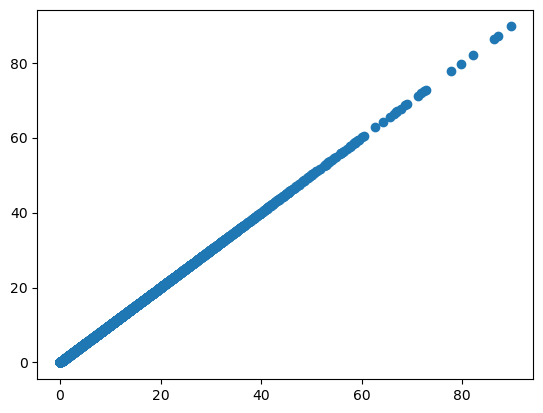

In [22]:
plt.scatter(a,b)

In [28]:
import matplotlib.pyplot as plt

def plot_tree_metrics(files, labels, colors, title="tree_metrics"):
    """
    Plot and save histograms of:
    1. Sublineage weight ratios (all internal nodes)
    2. Mean terminal / mean branch length ratios (all internal nodes)
    
    Parameters
    ----------
    files : list of str
        List of Newick tree files
    labels : list of str
        Labels for each tree
    colors : list of str
        Colors for plotting each tree
    title : str

    
        Title string used for saving the figure (default: "tree_metrics")
    """
    plt.figure(figsize=(12, 5))

    # --- Sublineage weight ratios ---
    plt.subplot(1, 2, 1)
    for file, lbl, col in zip(files, labels, colors):
        sub_lin_weight_ratio = all_sublineage_ratios_array(file)
        plt.hist(sub_lin_weight_ratio,
                 bins=50,
                 histtype='step',
                 linewidth=2.0,
                 density=True,
                 label=lbl,
                 color=col)
        print(file)
    plt.xlabel("Sublineage weight ratio (child/parent)")
    plt.ylabel("PDF")
    plt.yscale("log")
    plt.title("Sublineage Weight Ratios")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", alpha=0.5)

    # --- Mean terminal / mean branch length ratios ---
    plt.subplot(1, 2, 2)
    for file, lbl, col in zip(files, labels, colors):
        term_branch_ratio = parent_of_leaves_ratios_array_fast(file)
        plt.hist(term_branch_ratio,
                 bins=50,
                 histtype='step',
                 linewidth=2.0,
                 density=True,
                 label=lbl,
                 color=col)
        print(file)
    plt.xlabel("Mean terminal / mean branch length")
    plt.ylabel("PDF")
    plt.yscale("log")
    plt.title("Terminal vs Branch Length Ratios")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", alpha=0.5)

    plt.tight_layout()

    # --- Save and show ---
    filename = title.lower().replace(" ", "_") + ".png"
    plt.savefig(filename, dpi=300)
    print(f"✅ Figure saved as {filename}")
    plt.show()


../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk
../../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk
../../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk
../../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk
../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk
../../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk
../../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk
../../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk
✅ Figure saved as pse.png


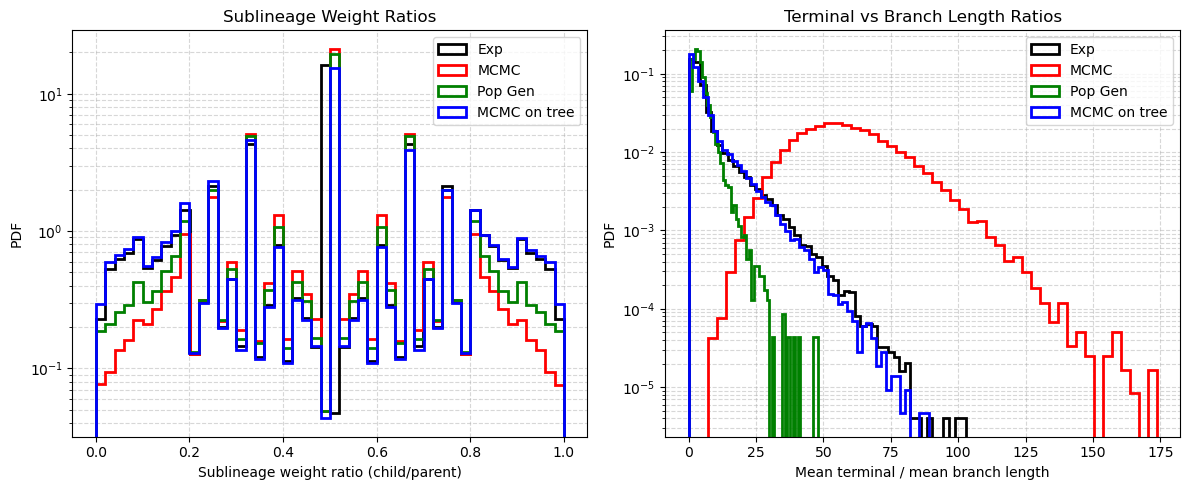

In [29]:
files = [
    "../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk",
    "../../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk"
]
labels = ["Exp", "MCMC", "Pop Gen", "MCMC on tree"]
colors = ["black", "red", "green", "blue"]

plot_tree_metrics(files, labels, colors, title="PSE")


../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk
../../data_directed_evolution/TreeSingleThread_TEM_round12.nwk
../../data_directed_evolution/TreeSingleThread_AAC6_round8.nwk
../../data_directed_evolution/TreeSingleThread_DHFR_round15.nwk
../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk
../../data_directed_evolution/TreeSingleThread_TEM_round12.nwk
../../data_directed_evolution/TreeSingleThread_AAC6_round8.nwk
../../data_directed_evolution/TreeSingleThread_DHFR_round15.nwk
✅ Figure saved as all_exp.png


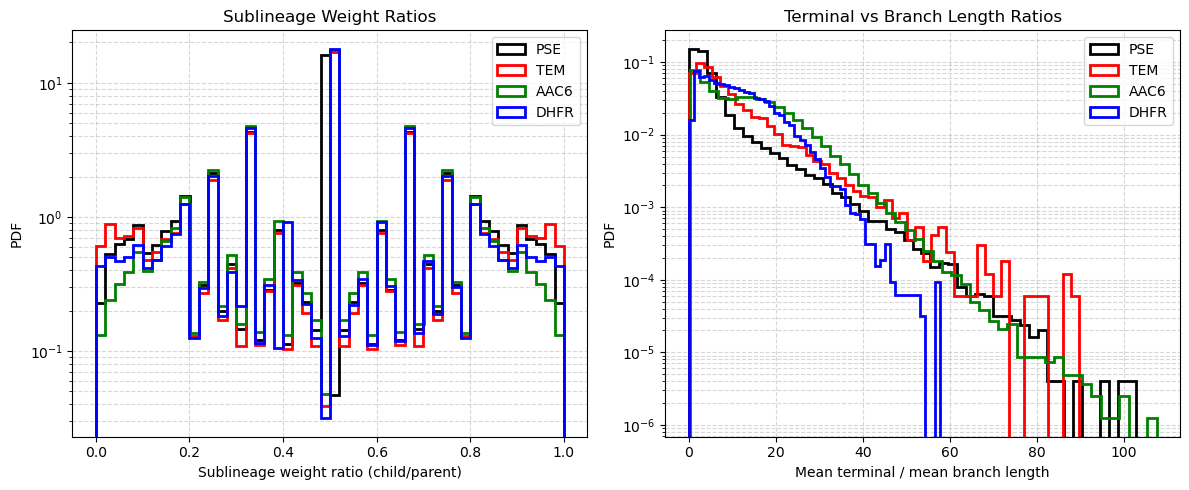

In [30]:
files = [
    "../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk",
    "../../data_directed_evolution/TreeSingleThread_TEM_round12.nwk",
    "../../data_directed_evolution/TreeSingleThread_AAC6_round8.nwk",
    "../../data_directed_evolution/TreeSingleThread_DHFR_round15.nwk",
]

labels = ["PSE", "TEM", "AAC6", "DHFR"]
colors = ["black", "red", "green", "blue"]

plot_tree_metrics(files, labels, colors, title="All_exp")


In [3]:
from Bio import Phylo
import numpy as np
import matplotlib.pyplot as plt

def terminal_branch_length_cdf(newick_file, ax=None, label=None, color=None):
    """
    Compute and optionally plot the empirical CDF of terminal branch lengths.
    
    Parameters
    ----------
    newick_file : str
        Path to the Newick tree file.
    ax : matplotlib.axes.Axes, optional
        Axis to plot on. If None, a new figure is created.
    label : str, optional
        Label for the curve (useful when comparing multiple trees).
    color : str, optional
        Color for the curve.
    
    Returns
    -------
    lengths : np.ndarray
        Sorted terminal branch lengths.
    cdf : np.ndarray
        Corresponding CDF values (from 0 to 1).
    """
    tree = Phylo.read(newick_file, "newick")
    
    # --- Extract terminal branch lengths ---
    lengths = [clade.branch_length for clade in tree.get_terminals() 
               if clade.branch_length is not None]
    lengths = np.array(lengths)
    lengths.sort()
    
    # --- Compute empirical CDF ---
    cdf = np.arange(1, len(lengths)+1) / len(lengths)
    
    # --- Plot if axis is provided ---
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(lengths, cdf, linewidth = 3., drawstyle="steps-post", label=label, color=color)
    ax.set_xlabel("Terminal branch length", fontsize = 15)
    ax.set_ylabel("Empirical CDF", fontsize = 15)
    #ax.set_title("Cumulative distribution of terminal branch lengths")
    if label is not None:
        ax.legend()
    
    return lengths, cdf


/tmp/ipykernel_217/4004651133.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("cdf_branch_length.png")
/opt/conda/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


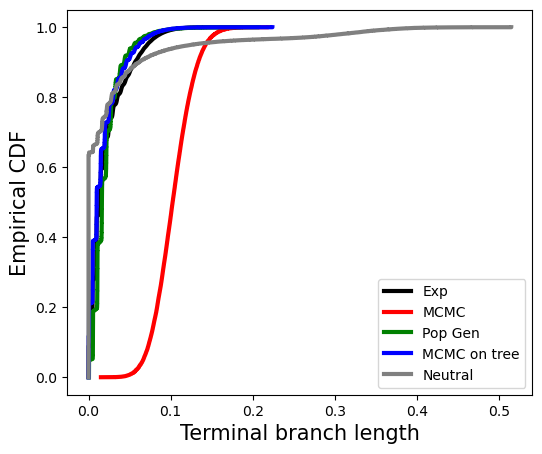

In [5]:
files = [
    "../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk",
    "../../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_popgen_samples100000_T0.0_mu0.03_mubind-50.0_pairs10000.nwk"
]
labels = ["Exp", "MCMC", "Pop Gen", "MCMC on tree", "Neutral"]
colors = ["black", "red", "green", "blue", "grey"]


fig, ax = plt.subplots(figsize=(6,5))

for path, label, color in zip(files, labels, colors):
    terminal_branch_length_cdf(path,label=label, ax = ax, color=color)

plt.savefig("cdf_branch_length.png")


Exp: Mean=0.0016, Std=0.0028, N=3
MCMC: Mean=0.0034, Std=0.0025, N=3
Pop Gen: Mean=0.0005, Std=0.0000, N=3
MCMC on tree: Mean=0.0022, Std=0.0022, N=3
Neutral: Mean=0.0006, Std=0.0000, N=3


/tmp/ipykernel_217/2867516349.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(all_branches, labels=labels, patch_artist=True)



Boxplot saved to root_branches_boxplot.png

Summary Statistics:
Exp             - Mean:   0.0016, Std:   0.0028, N: 3
MCMC            - Mean:   0.0034, Std:   0.0025, N: 3
Pop Gen         - Mean:   0.0005, Std:   0.0000, N: 3
MCMC on tree    - Mean:   0.0022, Std:   0.0022, N: 3
Neutral         - Mean:   0.0006, Std:   0.0000, N: 3


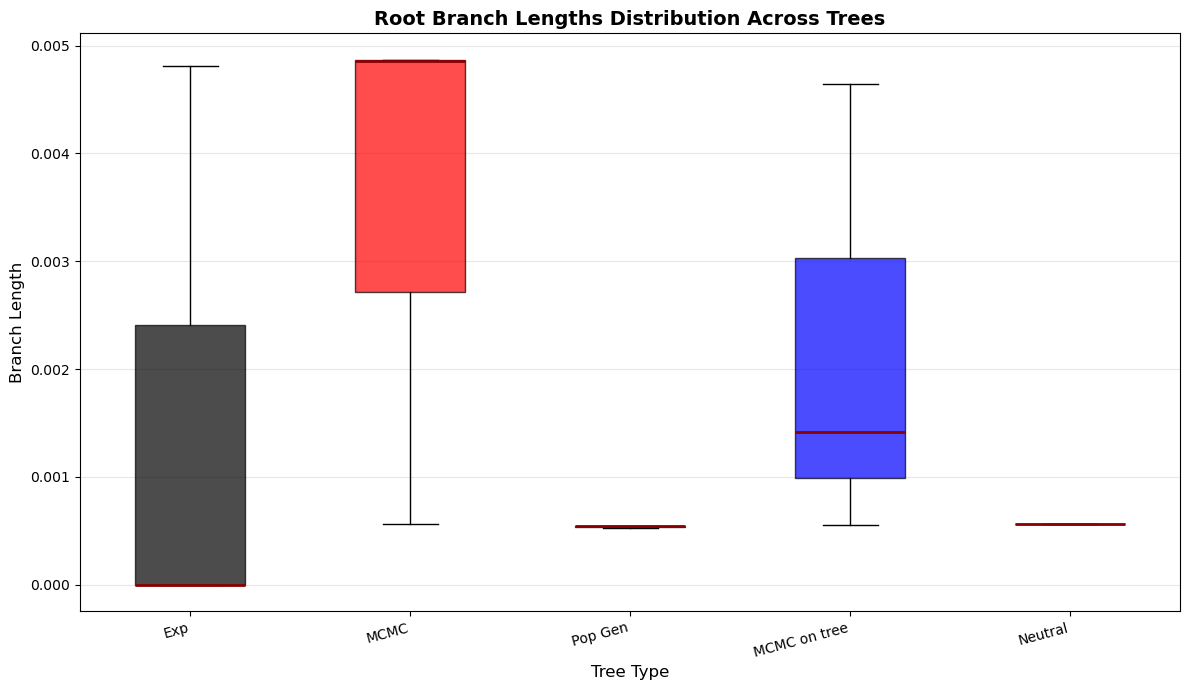

In [6]:
from Bio import Phylo
import matplotlib.pyplot as plt
import numpy as np

def analyze_root_branches(files, labels, colors, output_file='root_branches_boxplot.png'):
    """
    Analyze root branch lengths from multiple phylogenetic trees.
    
    Parameters:
    -----------
    files : list of str
        List of paths to tree files (Newick, Nexus, or PhyloXML format)
    labels : list of str
        List of labels for each tree
    colors : list of str
        List of colors for each boxplot
    output_file : str
        Path for saving the output boxplot
    
    Returns:
    --------
    dict : Statistics for each tree (mean, std, branch_lengths)
    """
    
    all_stats = {}
    all_branches = []
    
    # Process each tree file
    for i, (file, label) in enumerate(zip(files, labels)):
        # Read the tree - auto-detect format
        try:
            tree = Phylo.read(file, 'newick')
        except:
            try:
                tree = Phylo.read(file, 'nexus')
            except:
                tree = Phylo.read(file, 'phyloxml')
        
        # Get root node
        root = tree.root
        
        # Extract branch lengths from root to its direct children
        root_branches = []
        for child in root.clades:
            if child.branch_length is not None:
                root_branches.append(child.branch_length)
        
        if not root_branches:
            print(f"Warning: No branch lengths found for {label}")
            root_branches = [0]
        
        all_branches.append(root_branches)
        
        # Compute statistics
        all_stats[label] = {
            'branch_lengths': root_branches,
            'mean': np.mean(root_branches),
            'std': np.std(root_branches, ddof=1) if len(root_branches) > 1 else 0,
            'count': len(root_branches)
        }
        
        print(f"{label}: Mean={all_stats[label]['mean']:.4f}, Std={all_stats[label]['std']:.4f}, N={all_stats[label]['count']}")
    
    # Create boxplot
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Create box plot
    bp = ax.boxplot(all_branches, labels=labels, patch_artist=True)
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Color the medians
    for median in bp['medians']:
        median.set_color('darkred')
        median.set_linewidth(2)
    
    ax.set_ylabel('Branch Length', fontsize=12)
    ax.set_xlabel('Tree Type', fontsize=12)
    ax.set_title('Root Branch Lengths Distribution Across Trees', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=15, ha='right')
    
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"\nBoxplot saved to {output_file}")
    
    return all_stats


# Example usage:
if __name__ == "__main__":
    files = [
        "../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk",
        "../../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk",
        "../../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk",
        "../../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk",
        "../../data_directed_evolution/TreeSingleThread_PSE_popgen_samples100000_T0.0_mu0.03_mubind-50.0_pairs10000.nwk"
    ]
    labels = ["Exp", "MCMC", "Pop Gen", "MCMC on tree", "Neutral"]
    colors = ["black", "red", "green", "blue", "grey"]
    
    # Run analysis
    stats = analyze_root_branches(files, labels, colors)
    
    # Print summary statistics
    print("\n" + "="*60)
    print("Summary Statistics:")
    print("="*60)
    for label in labels:
        s = stats[label]
        print(f"{label:15s} - Mean: {s['mean']:8.4f}, Std: {s['std']:8.4f}, N: {s['count']}")

In [7]:
from Bio import Phylo
import matplotlib.pyplot as plt
import numpy as np

def analyze_root_to_leaves(files, labels, colors, output_file='root_to_leaves_boxplot.png'):
    """
    Analyze root-to-leaf distances from multiple phylogenetic trees.
    
    Parameters:
    -----------
    files : list of str
        List of paths to tree files (Newick, Nexus, or PhyloXML format)
    labels : list of str
        List of labels for each tree
    colors : list of str
        List of colors for each boxplot
    output_file : str
        Path for saving the output boxplot
    
    Returns:
    --------
    dict : Statistics for each tree (mean, std, distances)
    """
    
    all_stats = {}
    all_distances = []
    
    # Process each tree file
    for i, (file, label) in enumerate(zip(files, labels)):
        # Read the tree - auto-detect format
        try:
            tree = Phylo.read(file, 'newick')
        except:
            try:
                tree = Phylo.read(file, 'nexus')
            except:
                tree = Phylo.read(file, 'phyloxml')
        
        # Calculate distance from root to each leaf
        root_to_leaf_distances = []
        for leaf in tree.get_terminals():
            distance = tree.distance(tree.root, leaf)
            root_to_leaf_distances.append(distance)
        
        if not root_to_leaf_distances:
            print(f"Warning: No leaves found for {label}")
            root_to_leaf_distances = [0]
        
        all_distances.append(root_to_leaf_distances)
        
        # Compute statistics
        all_stats[label] = {
            'distances': root_to_leaf_distances,
            'mean': np.mean(root_to_leaf_distances),
            'std': np.std(root_to_leaf_distances, ddof=1) if len(root_to_leaf_distances) > 1 else 0,
            'min': np.min(root_to_leaf_distances),
            'max': np.max(root_to_leaf_distances),
            'count': len(root_to_leaf_distances)
        }
        
        print(f"{label}: Mean={all_stats[label]['mean']:.4f}, Std={all_stats[label]['std']:.4f}, "
              f"Range=[{all_stats[label]['min']:.4f}, {all_stats[label]['max']:.4f}], N={all_stats[label]['count']}")
    
    # Create boxplot
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Create box plot
    bp = ax.boxplot(all_distances, labels=labels, patch_artist=True)
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Color the medians
    for median in bp['medians']:
        median.set_color('darkred')
        median.set_linewidth(2)
    
    ax.set_ylabel('Distance from Root to Leaf', fontsize=12)
    ax.set_xlabel('Tree Type', fontsize=12)
    ax.set_title('Root-to-Leaf Distance Distribution Across Trees', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=15, ha='right')
    
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"\nBoxplot saved to {output_file}")
    
    return all_stats


# Example usage:
if __name__ == "__main__":
    files = [
        "../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk",
        "../../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk",
        "../../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk",
        "../../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk",
        "../../data_directed_evolution/TreeSingleThread_PSE_popgen_samples100000_T0.0_mu0.03_mubind-50.0_pairs10000.nwk"
    ]
    labels = ["Exp", "MCMC", "Pop Gen", "MCMC on tree", "Neutral"]
    colors = ["black", "red", "green", "blue", "grey"]
    
    # Run analysis
    stats = analyze_root_to_leaves(files, labels, colors)
    
    # Print summary statistics
    print("\n" + "="*80)
    print("Summary Statistics:")
    print("="*80)
    for label in labels:
        s = stats[label]
        print(f"{label:15s} - Mean: {s['mean']:8.4f}, Std: {s['std']:8.4f}, "
              f"Range: [{s['min']:8.4f}, {s['max']:8.4f}], N: {s['count']}")

KeyboardInterrupt: 

In [ ]:
from Bio import Phylo
import matplotlib.pyplot as plt

# Load the Newick tree
tree = Phylo.read("../../data_directed_evolution/TreeSingleThread_PSE_popgen_samples100000_T12.0_mu0.03_mubind-50.0_pairs10000.nwk", "newick")



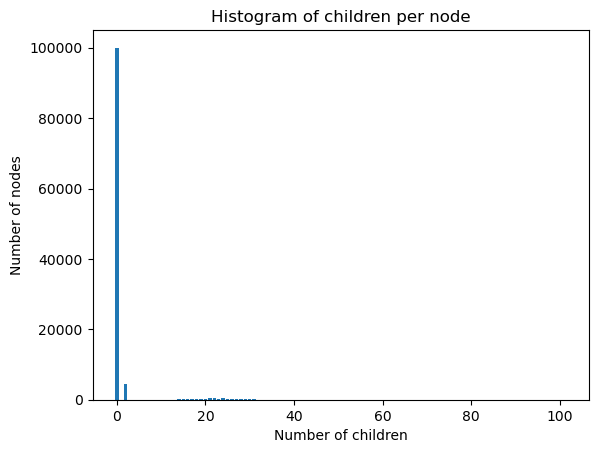

In [8]:
from Bio import Phylo
import matplotlib.pyplot as plt

# Load the Newick tree
tree = Phylo.read("../../data_directed_evolution/TreeSingleThread_PSE_popgen_samples100000_T12.0_mu0.03_mubind-50.0_pairs10000.nwk", "newick")

# Collect number of children for each node
children_counts = []

for clade in tree.find_clades():
    children_counts.append(len(clade.clades))  # number of children of this node

# Plot histogram
plt.hist(children_counts, bins=range(max(children_counts)+2), align="left", rwidth=0.8)
plt.xlabel("Number of children")
plt.ylabel("Number of nodes")
plt.title("Histogram of children per node")
plt.show()


In [9]:
from Bio import Phylo
import matplotlib.pyplot as plt

def plot_children_hist(newick_files, labels, colors):
    """
    Plot histograms of number of children per node for multiple Newick trees.
    
    Parameters
    ----------
    newick_files : list of str
        Paths to Newick files.
    labels : list of str
        Labels for each tree (used in the legend).
    colors : list of str
        Colors for each histogram.
    """
    plt.figure(figsize=(8, 6))

    for file, label, color in zip(newick_files, labels, colors):
        tree = Phylo.read(file, "newick")
        children_counts = [len(clade.clades) for clade in tree.find_clades()]

        plt.hist(
            children_counts,
            bins=range(max(children_counts) + 2),
            align="left",
            rwidth=0.6,
            alpha=0.5,
            label=label,
            color=color
        )

    plt.xlabel("Number of children")
    plt.ylabel("Number of nodes")
    plt.title("Histogram of children per node")
    plt.legend()
    plt.show()


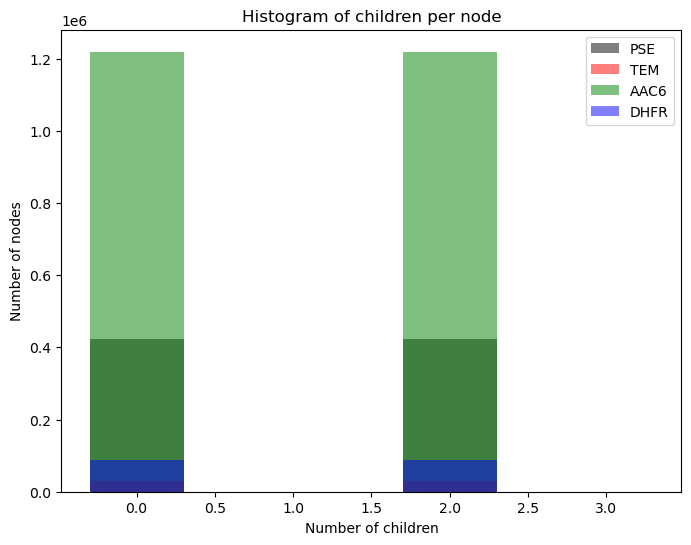

In [10]:
files = [
    "../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk",
    "../../data_directed_evolution/TreeSingleThread_TEM_round12.nwk",
    "../../data_directed_evolution/TreeSingleThread_AAC6_round8.nwk",
    "../../data_directed_evolution/TreeSingleThread_DHFR_round15.nwk",
]
labels = ["PSE", "TEM", "AAC6", "DHFR"]
colors = ["black", "red", "green", "blue"]
plot_children_hist(files, labels, colors)

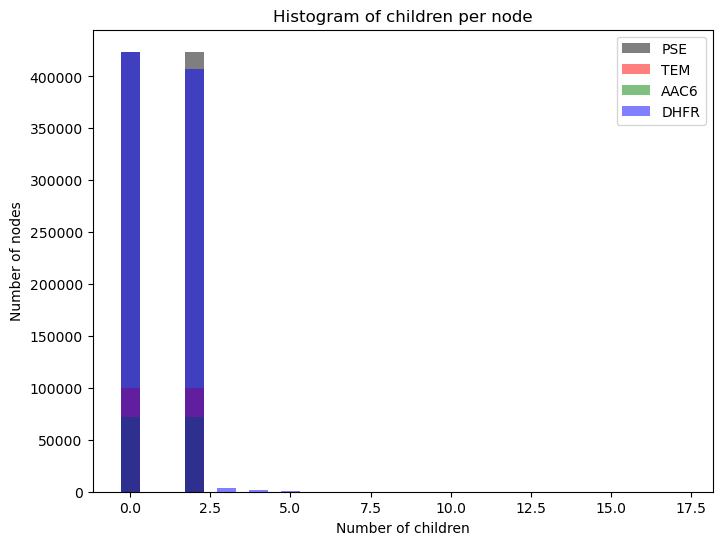

In [11]:
files = [
    "../../data_directed_evolution/TreeSingleThread_PSE_round20.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmc_samples100000_T1.3_steps120_pairs10000.nwk",
    "../../data_directed_evolution/TreeSingleThread_nodupl_PSE_popgen_samples1000000_T12.0_mu0.03_mubind-50.0_pairs10000.fa.nwk",
    "../../data_directed_evolution/TreeSingleThread_PSE_mcmctree_T1.4_steps110_pairs10000.nwk"
]
labels = ["PSE", "TEM", "AAC6", "DHFR"]
colors = ["black", "red", "green", "blue"]
plot_children_hist(files, labels, colors)